In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import shutil
from cpymad.madx import Madx

# BPM class

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Line without aperture generation

In [27]:
# Make line without apertures to avoid twiss errors
mad = Madx()
mad.call('sps.seq')
mad.beam()
mad.use('SPS')

line = xt.Line.from_madx_sequence(
    mad.sequence.SPS,
    deferred_expressions=True,
)

line.env.vars.load_madx('lhc_q20.str')
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180
line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180
line.particle_ref = xt.Particles.reference_from_pdg_id('proton',p0c=25.92e9)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.07.17 10:27:02      +
  ++++++++++++++++++++++++++++++++++++++++++++




  /**********************************************************************************

  *

  * SPS Ring version (draft)LS2 in MAD X SEQUENCE format

  * Generated the 26-MAY-2020 14:48:33 from Layout

  *

  ***********************************************************************************/









/************************************************************************************/

/*                       TYPES DEFINITION                                           */

/************************************************************************************/



//---------------------- COLLIMATOR     ---------------------------------------------

BSHV      : COLLIMATOR  , L := .45;       ! beam scraper,

Converting sequence "sps":   0%|          | 0/3794 [00:00<?, ?it/s]

In [28]:
tt = line.get_table()
tw_ref = line.twiss()

In [29]:
line['qd.51710'].shift_y = -5.273e-3
line['qfa.51810'].shift_y = -17.369e-3
line['qd.51910'].shift_y = -5.273e-3
line['qd.11710'].shift_x = -4.80e-3
line['qf.11810'].shift_x = -2.97e-3
line['qda.11910'].shift_x = -4.80e-3

In [30]:
tw = line.twiss()

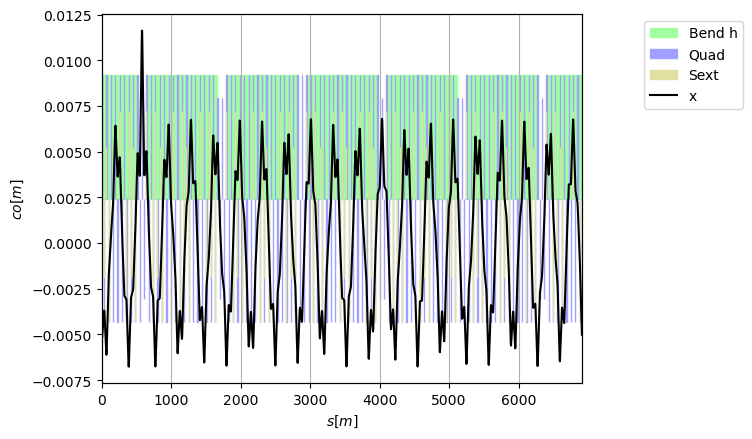

In [32]:
tw.plot('x')

In [35]:
tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
line.steering_monitors_x = tt_monitors.name
line.steering_monitors_y = tt_monitors.name

tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_82442/2037403802.py:5: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_82442/2037403802.py:5: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_82442/2037403802.py:9: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykerne

In [36]:
orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=5, n_iter=10)

Iteration 0, x_rms: 3.91e-03 -> 1.25e-04, y_rms: 1.57e-03 -> 3.45e-04
Iteration 1, x_rms: 1.25e-04 -> 1.24e-04, y_rms: 3.45e-04 -> 3.38e-04
Iteration 2, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.38e-04 -> 3.36e-04
Iteration 3, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.36e-04 -> 3.34e-04
Iteration 4, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.34e-04 -> 3.34e-04
Iteration 5, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.34e-04 -> 3.33e-04
Iteration 6, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.33e-04 -> 3.33e-04
Iteration 7, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.33e-04 -> 3.33e-04
Iteration 8, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.33e-04 -> 3.33e-04
Iteration 9, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 3.33e-04 -> 3.33e-04


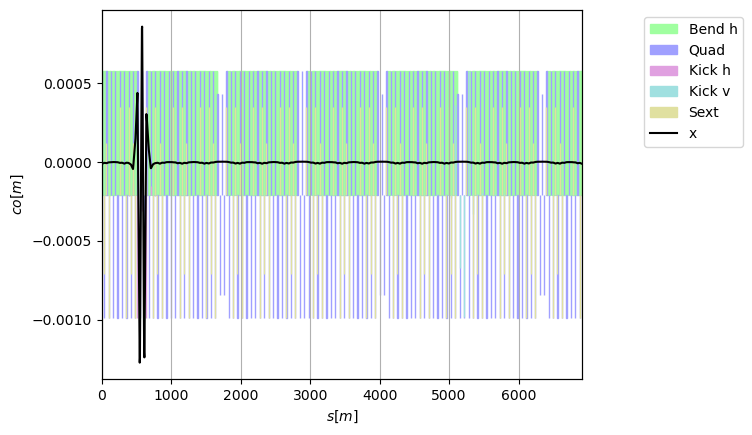

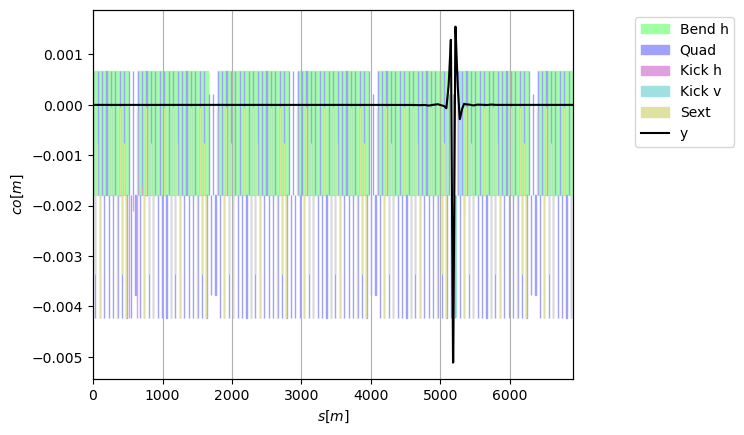

In [38]:
tw_after = line.twiss()
tw_after.plot('x')
tw_after.plot('y')

Loading line from dict:   0%|          | 0/4455 [00:00<?, ?it/s]

Done loading line from dict.           


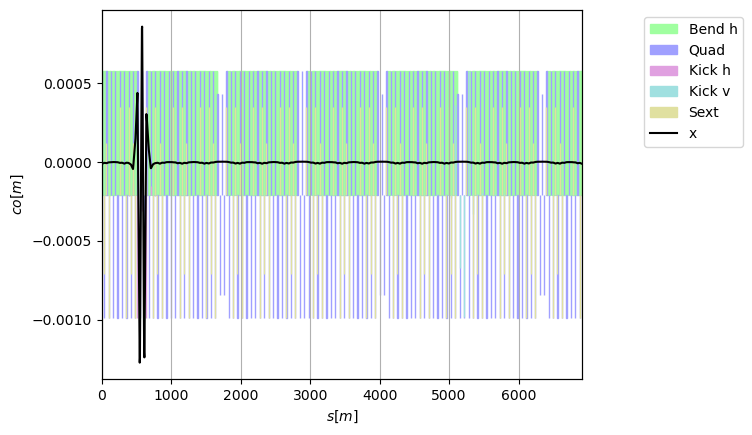

In [41]:
#Check if line works
line = xt.Line.from_json('sps_without_aperture_inj_q20.json')
tw = line.twiss()
tw.plot('x')

# Twiss orbit

In [3]:
line = xt.Line.from_json('sps_without_aperture_inj_q20.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/4455 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
tw.slip_factor, tw.momentum_compaction_factor

(np.float64(0.0017948126807497845), np.float64(0.003103448773362899))

## Verification of df formula via delta

In [20]:
def get_frequency_sweep(line, dR):
    tw = line.twiss()
    cav, _ = line.get_elements_of_type(xt.Cavity)
    f0 = cav[0].frequency
    gamma0 = tw.gamma0
    gamma_tr = 1/np.sqrt(tw.momentum_compaction_factor)
    beta0 = tw.beta0
    R = line.get_length()/(2*np.pi)

    res = (1 - gamma0**2/gamma_tr**2)*dR
    res -= 2* beta0**2 * gamma0**2 /R * dR**2
    res -= beta0**2 * gamma0**2 * gamma_tr**2/R**2 * dR**3
    res *= f0/R
    return res

def get_delta_sweep(line, dR):
    tw = line.twiss()
    eta = tw.slip_factor
    cav, _ = line.get_elements_of_type(xt.Cavity)
    f0 = cav[0].frequency
    return -get_frequency_sweep(line, dR) / (eta * f0) #sign problem ?

def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [6]:
get_straight_line(2500e-3, 500e-3,0, 3000e-3, -32e-3)

-0.0256

In [7]:
delta_calc = get_delta_sweep(line, get_straight_line(2500e-3, 500e-3,0, 3000e-3, -32e-3))

In [8]:
delta_calc

np.float64(-0.017325056227847153)

In [9]:
delta_emp = 0.307*get_straight_line(2500e-3, 500e-3,0, 3000e-3, -32e-3)

In [13]:
delta_emp2 = 0.338*get_straight_line(2500e-3, 500e-3,0, 3000e-3, -32e-3)

In [14]:
delta_emp2 #real one in machine

-0.0086528

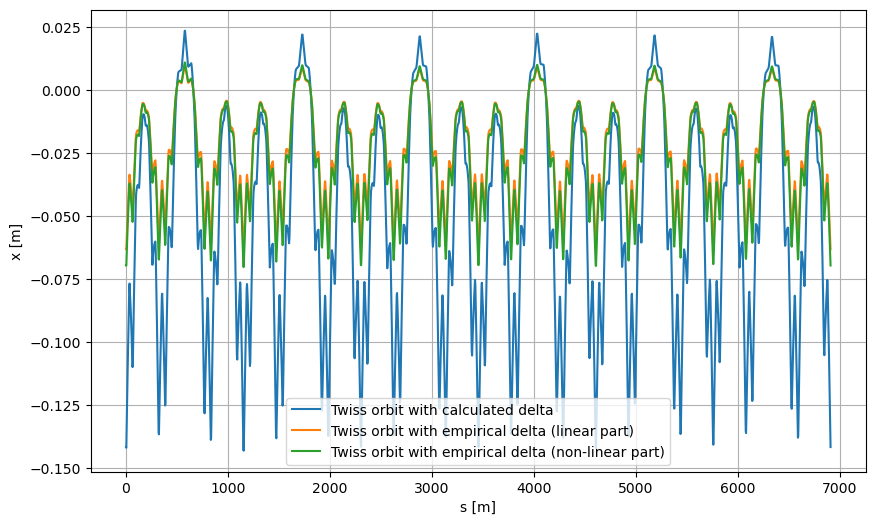

In [15]:
tw_offmomentum_calc = line.twiss(delta0=delta_calc)
tw_offmomentum_emp = line.twiss(delta0=delta_emp)
tw_offmomentum_emp2 = line.twiss(delta0=delta_emp2)

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(tw_offmomentum_calc.s, tw_offmomentum_calc.x, label='Twiss orbit with calculated delta')
ax.plot(tw_offmomentum_emp.s, tw_offmomentum_emp.x, label='Twiss orbit with empirical delta (linear part)')
ax.plot(tw_offmomentum_emp2.s, tw_offmomentum_emp2.x, label='Twiss orbit with empirical delta (non-linear part)')

ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.legend()
ax.grid()

It looks like a similar negative sweep gives the same type of orbit variations as the bpms, at least for the empirical delta (calculated delta wit formula is bigger, hence a more important orbit change)

# Tracking test without aperture

In [337]:
line = xt.Line.from_json('sps_without_aperture_inj_q20.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']

cav, _ = line.get_elements_of_type(xt.Cavity)
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/4455 [00:00<?, ?it/s]

Done loading line from dict.           


In [282]:
sweep = get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3))

In [283]:
delta_sweep = get_delta_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3))

In [284]:
sweep, delta_sweep

(np.float64(5364.2623264110925), np.float64(-0.014943990028672336))

In [338]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 1
plane = 'DPneg'
sweep = get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3))
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = int(get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3)))

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [339]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*'].name
env = line.env
insertions = []
for name in bph_list:
    env.elements[f'{name}_monitor'] = xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1)
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/4426 [00:00<?, ?it/s]

In [340]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/4531 [00:00<?, ?it/s]

In [341]:
# part = xt.Particles(
#     x = np.ones(num_particles) * tw.particle_on_co.x[0], #np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
#     px = np.ones(num_particles) * tw.particle_on_co.px[0],
#     y = np.ones(num_particles) * tw.particle_on_co.y[0],
#     py = np.ones(num_particles) * tw.particle_on_co.py[0],
#     delta = np.ones(num_particles) * tw.particle_on_co.delta[0],#np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
#     zeta = np.ones(num_particles) * tw.particle_on_co.zeta[0],
#     p0c = np.ones(num_particles) * tw.particle_on_co.p0c[0],
# )
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610109981524263m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004885
--> Emittance: 0.3019505331641999


In [342]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 1.0000489049983394Hz per turn until 200005364.26232642 (for 5364 turns).
This sweep will move the center of the bucket with Δδ = -0.014943990028650935 (-2.321382853735299 buckets).
All particles lost at turn 3399, stopped sweep at 3399.166228Hz.


In [343]:
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
x_positions = []

for turn in range(num_turns):
    x_turn = []
    for monitor in monitors:
        x_turn.append(line[monitor].x[0][turn])
    x_positions.append(x_turn)

In [347]:
part.state

array([-331])

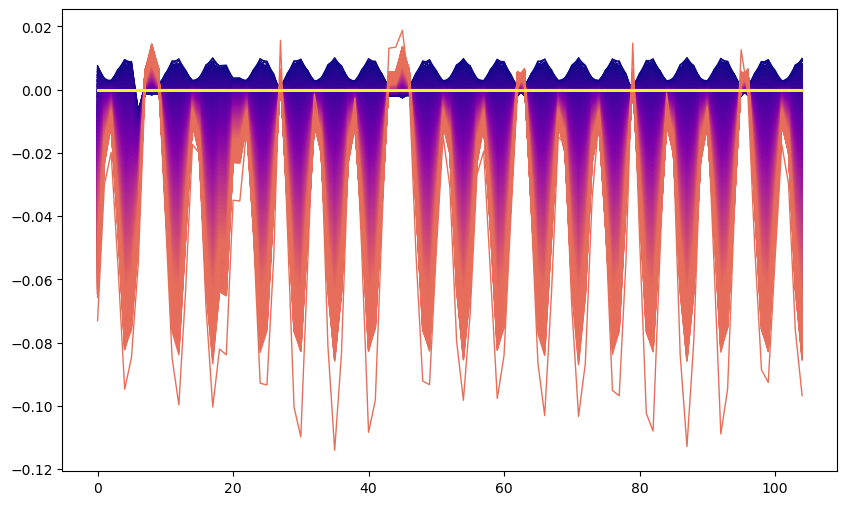

In [346]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
for i, x_turn in enumerate(x_positions):
    ax.plot(x_turn, label='Turn {}'.format(i), color=cmap(i / len(x_positions)), linewidth=1)

0
1
2
3
4
5
6
7
8
9


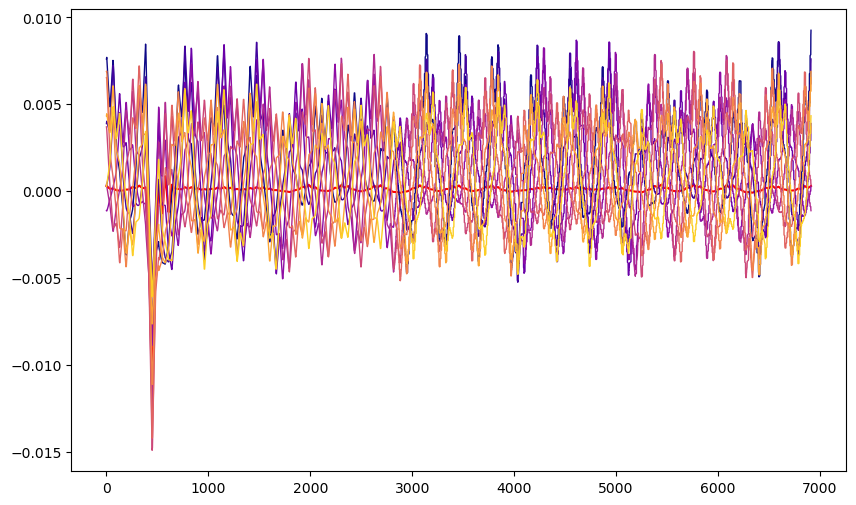

In [292]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
ax.plot(tw_after.s, tw_after.x, color='red')
for t in range(10):
    print(t)
    ax.plot(tw.s,res[len(res)-1-t][:-1], lw=1, color=cmap(t/10))

In [293]:
part.delta

LinkedArrayCpu([0.00056844])

In [251]:
tw_after = line.twiss()

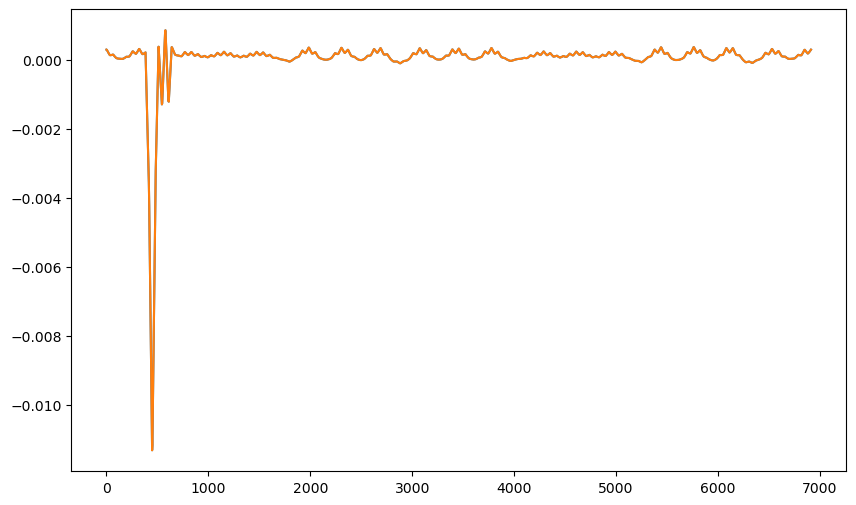

In [129]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(tw.s, tw.x, label='Twiss orbit')
ax.plot(tw_after.s, tw_after.x, label='Twiss orbit after tracking')

In [131]:
line_ref = xt.Line.from_json('sps_without_aperture_inj_q20.json')
tw_ref = line_ref.twiss()

Loading line from dict:   0%|          | 0/4455 [00:00<?, ?it/s]

Done loading line from dict.           


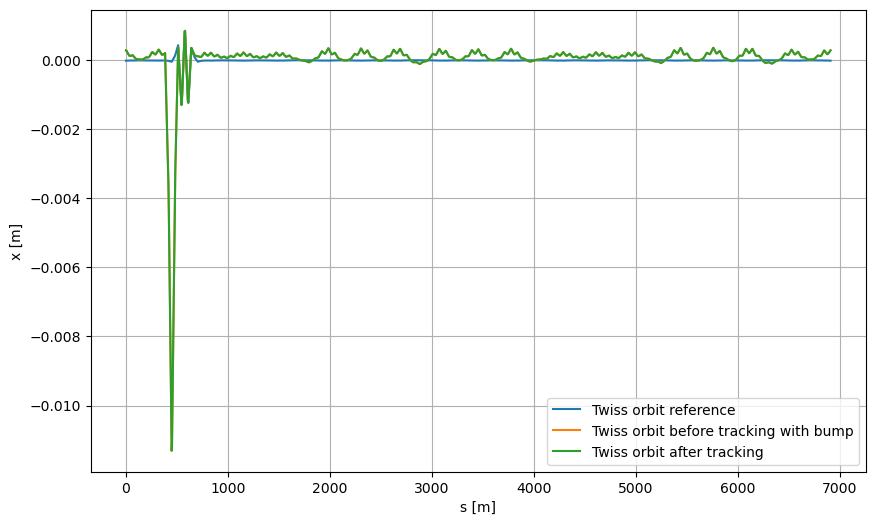

In [150]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(tw_ref.s, tw_ref.x, label='Twiss orbit reference')
ax.plot(tw_before_with_bump.s, tw_before_with_bump.x, label='Twiss orbit before tracking with bump')
ax.plot(tw_after.s, tw_after.x, label='Twiss orbit after tracking')
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.legend()
ax.grid()
#ax.set_ylim(-0.00001, 0.00001)

In [153]:
np.mean(tw_before_with_bump.x[tw_before_with_bump.s > 1000])

np.float64(0.00010400192643906477)

bump moves the orbit positively, but the steering does not seem to do anything to the orbit?

In [184]:
line = xt.Line.from_json('sps_without_aperture_inj_q20.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/4455 [00:00<?, ?it/s]

Done loading line from dict.           


In [185]:
tw_before_with_bump_offmomentum = line.twiss(delta0=delta_emp2)

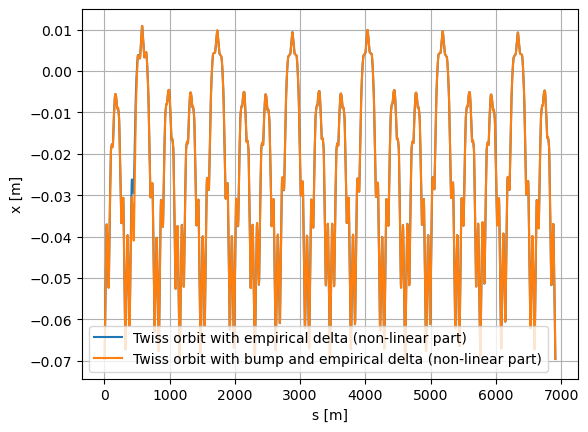

In [187]:
plt.plot(tw_offmomentum_emp2.s, tw_offmomentum_emp2.x, label='Twiss orbit with empirical delta (non-linear part)')
plt.plot(tw_before_with_bump_offmomentum.s, tw_before_with_bump_offmomentum.x, label='Twiss orbit with bump and empirical delta (non-linear part)')
plt.xlabel('s [m]')
plt.ylabel('x [m]')
plt.legend()
plt.grid()

In [189]:
part.delta

LinkedArrayCpu([0.00185537])

In [307]:
tt = line.get_table()

In [309]:
tt.rows['bph.*']

Table: 105 rows, 11 cols
name                  s element_type isthick isreplica parent_name iscollective       s_start ...
bph.10208       63.6255 Drift           True     False None               False       63.6255
bph.10408       127.621 Drift           True     False None               False       127.621
bph.10608       191.617 Drift           True     False None               False       191.617
bph.10808       255.612 Drift           True     False None               False       255.612
bph.11008       319.608 Drift           True     False None               False       319.608
bph.11208       383.603 Drift           True     False None               False       383.603
bph.11408       447.599 Drift           True     False None               False       447.599
bph.11608       511.594 Drift           True     False None               False       511.594
bph.11831       579.566 Drift           True     False None               False       579.566
bph.12008       639.585 Drift  

# Tracking with apertures

## delta calculated given dr

In [356]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']

cav, _ = line.get_elements_of_type(xt.Cavity)
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [357]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 1
plane = 'DPneg'
sweep = get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3))
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = int(get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3)))

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [358]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*..0'].name
env = line.env
insertions = []
for name in bph_list:
    env.elements[f'{name}_monitor'] = xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1)
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

In [360]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/33116 [00:00<?, ?it/s]

In [362]:
part = xt.Particles(
    x = np.ones(num_particles) * tw.particle_on_co.x[0], #np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
    px = np.ones(num_particles) * tw.particle_on_co.px[0],
    y = np.ones(num_particles) * tw.particle_on_co.y[0],
    py = np.ones(num_particles) * tw.particle_on_co.py[0],
    delta = np.ones(num_particles) * tw.particle_on_co.delta[0],#np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
    zeta = np.ones(num_particles) * tw.particle_on_co.zeta[0],
    p0c = np.ones(num_particles) * tw.particle_on_co.p0c[0],
)
# part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
#                                           nemitt_y=2e-6,
#                                           sigma_z=0.224, num_particles=num_particles, line=line)

In [363]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 1.0001127648508374Hz per turn until 200005364.60487065 (for 5364 turns).
This sweep will move the center of the bucket with Δδ = -0.014944039761328735 (-2.321458508950537 buckets).
All particles lost at turn 2888, stopped sweep at 2888.325665Hz.


In [ ]:
turn_max = part.at_turn[0]
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
s_positions_monitors = tt.rows['.*monitor.*'].s
x_positions = []

for turn in range(turn_max):
    x_turn = []
    for monitor in monitors:
        x_turn.append(line[monitor].x[0][turn])
    x_positions.append(x_turn)

In [368]:
s_positions_monitors = tt.rows['.*monitor.*'].s

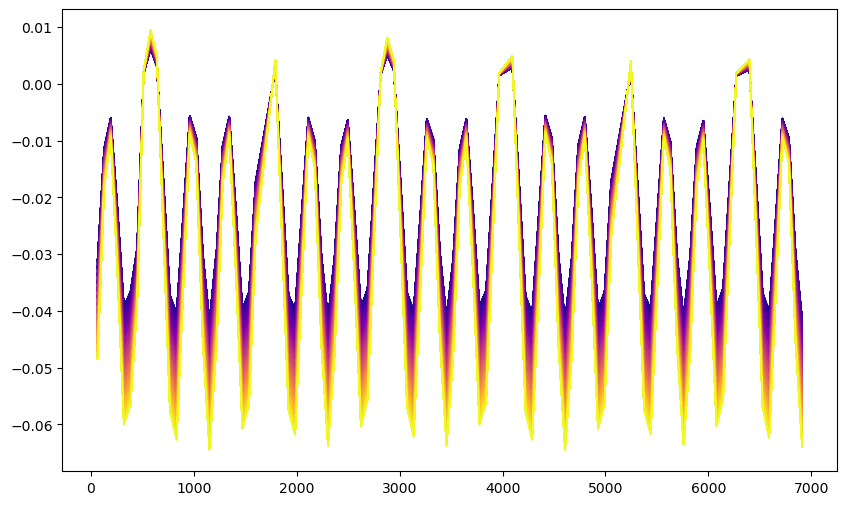

In [385]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
counter = 0
for i, x_turn in enumerate(x_positions):
    if i > len(x_positions) - 1024:
        ax.plot(s_positions_monitors, x_turn, label='Turn {}'.format(i), color=cmap(counter / 1024), linewidth=1)
        counter +=1

# df calculated given empirical delta

In [401]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']

cav, _ = line.get_elements_of_type(xt.Cavity)
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [392]:
dr = get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
print(1/tw_ref.momentum_compaction_factor * dr/line.get_length()/(np.pi*2))
print(0.307*dr) 
#shows there is a problem with the 'normal' formula

-0.00016323834031193026
-0.006754


In [395]:
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = -delta_emp * cav[0].frequency * tw_ref.slip_factor

In [394]:
sweep

np.float64(-2424.4668469321823)

In [402]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 1
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = int(get_frequency_sweep(line, get_straight_line(1.967, 1.027,0, 1.967, -22e-3)))

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [403]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*..0'].name
env = line.env
insertions = []
for name in bph_list:
    env.elements[f'{name}_monitor'] = xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1)
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

In [404]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/33116 [00:00<?, ?it/s]

In [405]:
part = xt.Particles(
    x = np.ones(num_particles) * tw.particle_on_co.x[0], #np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
    px = np.ones(num_particles) * tw.particle_on_co.px[0],
    y = np.ones(num_particles) * tw.particle_on_co.y[0],
    py = np.ones(num_particles) * tw.particle_on_co.py[0],
    delta = np.ones(num_particles) * tw.particle_on_co.delta[0],#np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
    zeta = np.ones(num_particles) * tw.particle_on_co.zeta[0],
    p0c = np.ones(num_particles) * tw.particle_on_co.p0c[0],
)
# part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
#                                           nemitt_y=2e-6,
#                                           sigma_z=0.224, num_particles=num_particles, line=line)

In [406]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.45198859935350155Hz per turn until 200002424.46684694 (for 5364 turns).
This sweep will move the center of the bucket with Δδ = -0.0067537740120869475 (-1.0491544721702617 buckets).


In [407]:
turn_max = part.at_turn[0]
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
s_positions_monitors = tt.rows['.*monitor.*'].s
x_positions = []

for turn in range(turn_max):
    x_turn = []
    for monitor in monitors:
        x_turn.append(line[monitor].x[0][turn])
    x_positions.append(x_turn)

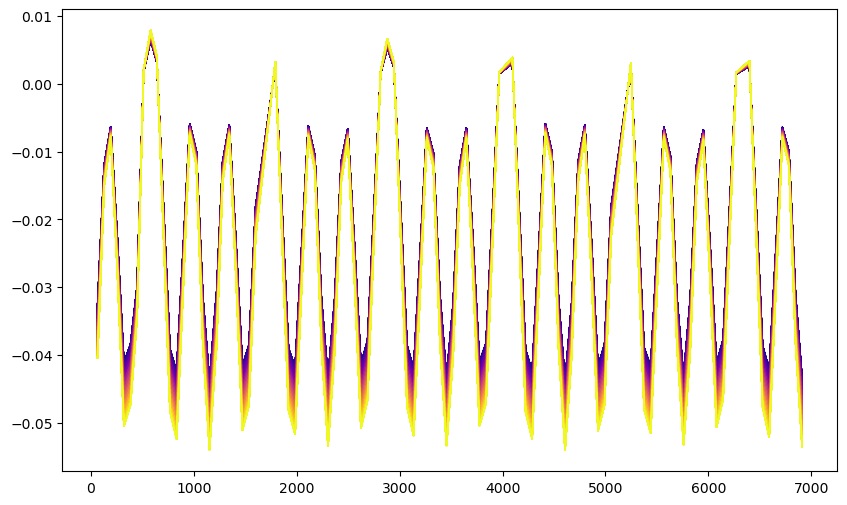

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
counter = 0
for i, x_turn in enumerate(x_positions):
    if i > len(x_positions) - 1024:
        ax.plot(s_positions_monitors, x_turn, label='Turn {}'.format(i), color=cmap(counter / 1024), linewidth=1)
        counter +=1

# With tune shift and chroma

In [418]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [419]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 1
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [420]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*..0'].name
env = line.env
insertions = []
for name in bph_list:
    env.elements[f'{name}_monitor'] = xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1)
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/33012 [00:00<?, ?it/s]

In [421]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/33116 [00:00<?, ?it/s]

In [422]:
part = xt.Particles(
    x = np.ones(num_particles) * tw.particle_on_co.x[0], #np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
    px = np.ones(num_particles) * tw.particle_on_co.px[0],
    y = np.ones(num_particles) * tw.particle_on_co.y[0],
    py = np.ones(num_particles) * tw.particle_on_co.py[0],
    delta = np.ones(num_particles) * tw.particle_on_co.delta[0],#np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
    zeta = np.ones(num_particles) * tw.particle_on_co.zeta[0],
    p0c = np.ones(num_particles) * tw.particle_on_co.p0c[0],
)
# part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
#                                           nemitt_y=2e-6,
#                                           sigma_z=0.224, num_particles=num_particles, line=line)

In [423]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.3463524067045975Hz per turn until 200002424.46684694 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.0068273235873477075 (-1.0548517251234861 buckets).


In [424]:
turn_max = part.at_turn[0]
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
s_positions_monitors = tt.rows['.*monitor.*'].s
x_positions = []

for turn in range(turn_max):
    x_turn = []
    for monitor in monitors:
        x_turn.append(line[monitor].x[0][turn])
    x_positions.append(x_turn)

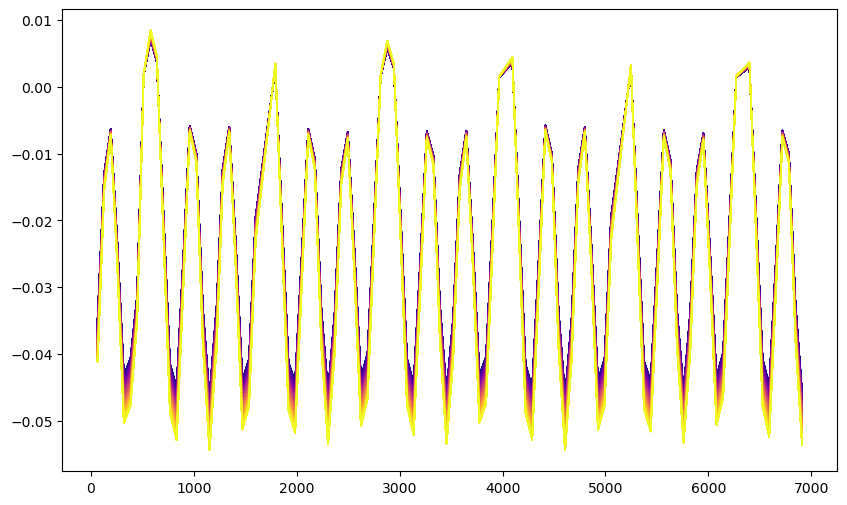

In [425]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
counter = 0
for i, x_turn in enumerate(x_positions):
    if i > len(x_positions) - 1024:
        ax.plot(s_positions_monitors, x_turn, label='Turn {}'.format(i), color=cmap(counter / 1024), linewidth=1)
        counter +=1

# Comparison xsuite - real data

## Loading data studf

In [427]:
df_params = pd.read_json('../../MD_data/20250616/parameters.json').T
df_params.index = pd.to_datetime(df_params.index) #convert index (string timestamp) to datetime
df_params.index = df_params.index.tz_localize("Europe/Paris") #Set to Geneva time

In [432]:
import numpy as np
import awkward as ak
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import json
from zoneinfo import ZoneInfo

In [433]:
directory = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2')
paths_files_list = list(directory.glob("*.parquet"))
path_files = {}
for path in paths_files_list:
    stem = path.stem
    dt = datetime.strptime(stem, "%Y.%m.%d.%H.%M.%S.%f")
    dt = dt.replace(tzinfo=ZoneInfo("Europe/Paris"))
    path_files[dt] = path
path_files = pd.DataFrame.from_dict(path_files, orient='index', columns=['path'])
path_files.index = pd.to_datetime(path_files.index)
print(path_files.index.is_monotonic_increasing)
path_files = path_files.sort_index() #Files need to be sorted by index for correct time series handling
print(path_files.index.is_monotonic_increasing)

False
True


In [434]:
df_fo = pd.read_json('../../MD_data/20250616/full_overview.json').T
df_fo.index = pd.to_datetime(df_fo.index) #convert index (string timestamp) to datetime
df_fo.index = df_fo.index.tz_localize("Europe/Paris") #Set to Geneva time

In [436]:
# Making new dict with paths per timestamp
changes_ts = df_params.index.to_numpy()
paths_per_ts = {}
for ts_start, ts_end in zip(changes_ts[:-1], changes_ts[1:]):
    ll = df_fo.loc[ts_start:ts_end-dt].index.to_numpy()
    lll = path_files.loc[ts_start:ts_end-dt, "path"].to_numpy()
    
    for i in range(len(ll)):
        paths_per_ts[ll[i]] = lll[i]
paths_per_ts = pd.DataFrame.from_dict(paths_per_ts, orient='index', columns=['path'])

In [437]:
selected_ts = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33"].index.to_numpy()
selected_paths = paths_per_ts.loc["2025-06-16 20:04:11":"2025-06-16 20:05:33", "path"].to_numpy()

In [438]:
bpm_dict = {}
for i,path in enumerate(selected_paths):
    bpm_dict[selected_ts[i]] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

In [439]:
hor_turn_position = bpm_dict[selected_ts[0]].hor_turn_position
s_pos = line.get_s_position([f'{bpm}..0' for bpm in bpm_dict[selected_ts[0]].bpms_hor if f'{bpm}..0' in line.element_names])

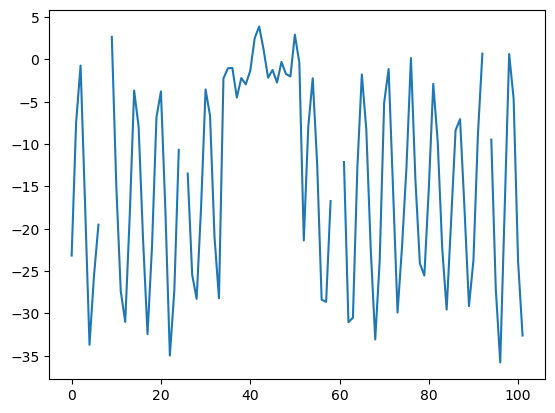

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')

ax.plot